In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap
import sys

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from utils import *

## Loading data

In [2]:
path = ''
df_original = pd.read_excel(path + 'data/default of credit card clients.xls', header=1)
df_original.columns = ['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 
                       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
                       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 
                       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4',
                       'pay_amt5', 'pay_amt6', 'payment_next_month']
df_original.drop('id', axis=1, inplace=True)
print(df_original.shape)
df_original.head()

(30000, 24)


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Preprocessing

In [3]:
df_proces = df_original.copy()

df_proces.loc[df_proces['marriage'] == 0, 'marriage'] = 3
df_proces.loc[df_proces['education'].isin([0, 5, 6]), 'education'] = 4
df_proces['sex'] = df_proces['sex'].apply(lambda row: 0 if row == 2 else 1)

columns_cat = ['education', 'marriage']

df_proces = pd.get_dummies(df_proces, columns=columns_cat)
df_proces = df_proces.astype(float)
df_proces.head()

,limit_bal,sex,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,payment_next_month,education_1,education_2,education_3,education_4,marriage_1,marriage_2,marriage_3
0,20000.0,0.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,120000.0,0.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,90000.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,50000.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,50000.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [4]:
metadata = {'label_maps': [{0.0: 'no', 1.0: 'yes'}], 
            'protected_attribute_maps': [{0.0: 'female', 1.0: 'male'}]}
unprivileged_groups=[{'sex': [0.0]}]
privileged_groups=[{'sex': [1.0]}]
protected_attribute_names = ['sex']
label_names = ['payment_next_month']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 1
name_protect = 'sex'

Disparate impact dados originais:  0.14031177319235133


In [5]:
lst_res = []

## Model with original data

In [6]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)   
X_train_orig = scale.transform(dataset_train.features)     
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)  
y_test = dataset_test.labels.ravel()

### Random Forest

In [7]:
model_orig_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
print('RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_rf, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'default', 'rf_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: 

Test accuracy:  0.8357777777777777
Train accuracy:  0.8492857142857143
Disparate impact:  0.772603872409074
Mean difference:  -0.025927167234563925
Average odds difference: -0.01772333614939113
Equality of opportunity: -0.025203392432266436
False discovery rate difference: 0.010930231357424214
Generalized entropy index: 0.09572586972546063
Consistency:  0.9677111111111113


### Gradient Boosting

In [9]:
model_orig_gbm = GradientBoostingClassifier()
model_orig_gbm.fit(X_train_orig, y_train) 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [10]:
print('RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_gbm, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'default', 'gbm_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 

Test accuracy:  0.8372222222222222
Train accuracy:  0.8205714285714286
Disparate impact:  0.7803371890909883
Mean difference:  -0.02567000718896896
Average odds difference: -0.012635327348511059
Equality of opportunity: -0.012443395502340915
False discovery rate difference: -0.009270072992700773
Generalized entropy index: 0.09457907649956042
Consistency:  0.9697333333333334


### Logistic Regression

In [11]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
print('RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_lr, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'default', 'lr_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: 

Test accuracy:  0.8233333333333334
Train accuracy:  0.806047619047619
Disparate impact:  0.6138484739733173
Mean difference:  -0.030633004197169307
Average odds difference: -0.033855698966191894
Equality of opportunity: -0.05345767134853019
False discovery rate difference: -0.032056703314405355
Generalized entropy index: 0.1063914252355697
Consistency:  0.975088888888889


## Model with transformed data

In [13]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [14]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  -4.440892098500626e-16


In [15]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [16]:
model_transf_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
print('RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_rf, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'default', 'rf_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: 

Test accuracy:  0.8357777777777777
Train accuracy:  0.8492380952380952
Disparate impact:  0.7818025551101973
Mean difference:  -0.024382028956978247
Average odds difference: -0.014897065932138086
Equality of opportunity: -0.01998426586844726
False discovery rate difference: 0.008919132841426425
Generalized entropy index: 0.09583317625910685
Consistency:  0.9692000000000002


### Gradient Boosting

In [18]:
model_transf_gbm = GradientBoostingClassifier()
model_transf_gbm.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [19]:
print('RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_gbm, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'default', 'gbm_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 

Test accuracy:  0.8377777777777777
Train accuracy:  0.820952380952381
Disparate impact:  0.815495496816565
Mean difference:  -0.02087938364145782
Average odds difference: -0.005095651470247285
Equality of opportunity: -0.00017269168777339639
False discovery rate difference: -0.002919737025046165
Generalized entropy index: 0.09429696357709755
Consistency:  0.9697111111111113


### Logistic Regression

In [20]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
print('RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_lr, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'default', 'lr_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: 

Test accuracy:  0.8237777777777778
Train accuracy:  0.8053333333333333
Disparate impact:  0.8881437730607894
Mean difference:  -0.007442239722426865
Average odds difference: 0.0064096038012363705
Equality of opportunity: 0.016079514928237004
False discovery rate difference: 0.005460588793922139
Generalized entropy index: 0.10601813833994504
Consistency:  0.9754222222222223


In [22]:
cols_name = ['dataset', 'name_exp', 'acc_test', 'disp_impact_bin', 'mean_difference',
             'disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)
df_final

,dataset,name_exp,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,default,rf_orig,0.835778,0.772604,-0.025927,0.772604,-0.017723,-0.025203,0.010930,0.095726,0.967711
1,default,gbm_orig,0.837222,0.780337,-0.025670,0.780337,-0.012635,-0.012443,-0.009270,0.094579,0.969733
2,default,lr_orig,0.823333,0.613848,-0.030633,0.613848,-0.033856,-0.053458,-0.032057,0.106391,0.975089
3,default,rf_transf,0.835778,0.781803,-0.024382,0.781803,-0.014897,-0.019984,0.008919,0.095833,0.969200
4,default,gbm_transf,0.837778,0.815495,-0.020879,0.815495,-0.005096,-0.000173,-0.002920,0.094297,0.969711
5,default,lr_transf,0.823778,0.888144,-0.007442,0.888144,0.006410,0.016080,0.005461,0.106018,0.975422


## SHAP

In [23]:
lst_shape = []

### Random Forest

RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: 



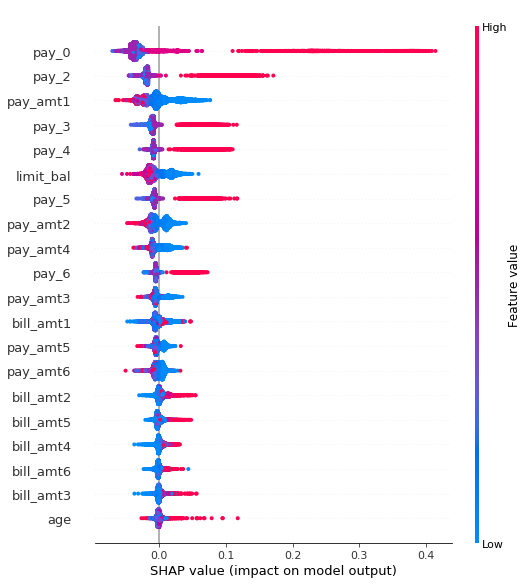

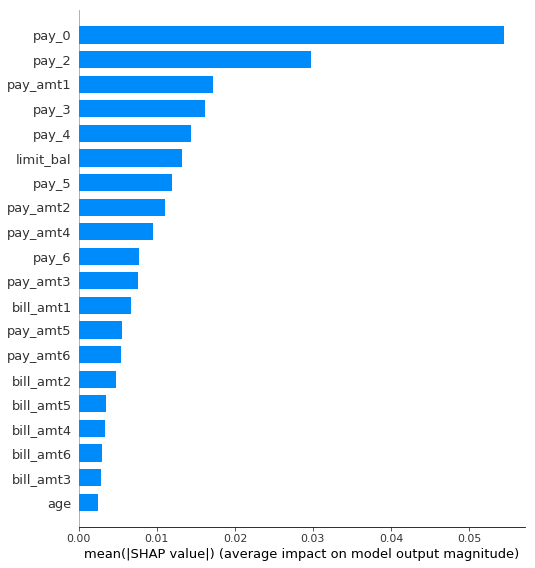

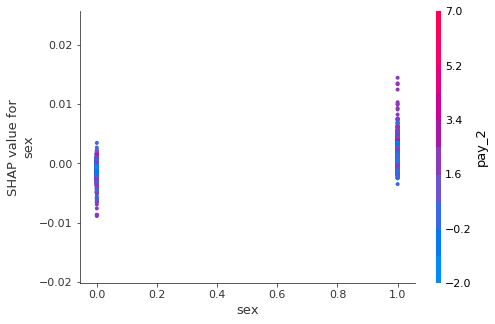

Mean SHAP value unprivileged class:  -0.0008656480197846351
Mean SHAP value privileged class:  0.001430149917368719
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [24]:
print('RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_rf, 'rf_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [25]:
print('Global SHAP values by feature of Random Forest with original data: ')
df_feat

Global SHAP values by feature of Random Forest with original data: 


,feature_names,value
0,pay_0,0.054486
1,pay_2,0.029753
2,pay_amt1,0.017156
3,pay_3,0.016123
4,pay_4,0.014357
5,limit_bal,0.013238
6,pay_5,0.011922
7,pay_amt2,0.011098
8,pay_amt4,0.009474
9,pay_6,0.007701


RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: 



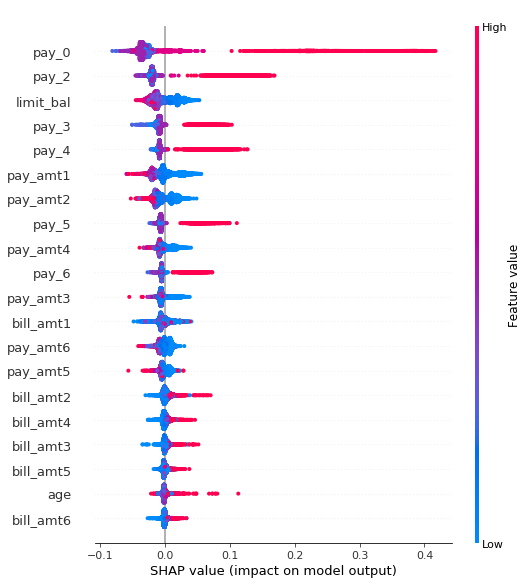

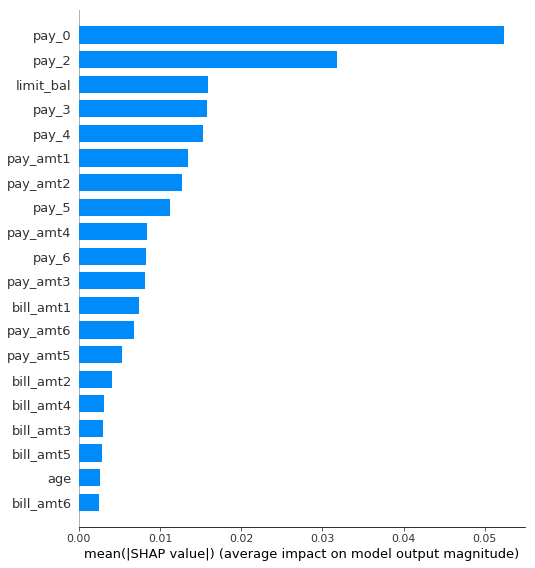

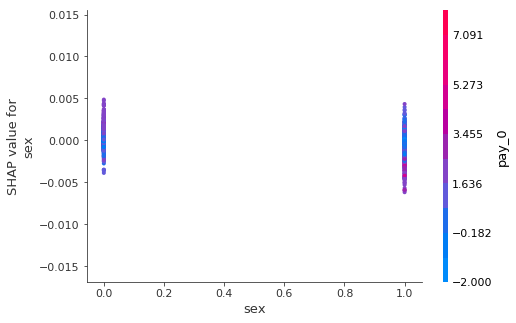

Mean SHAP value unprivileged class:  0.0002519503107413124
Mean SHAP value privileged class:  -0.0003029714401732245
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [26]:
print('RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_rf, 'rf_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [27]:
print('Global SHAP values by feature of Random Forest with transformed data: ')
df_feat

Global SHAP values by feature of Random Forest with transformed data: 


,feature_names,value
0,pay_0,0.052363
1,pay_2,0.031795
2,limit_bal,0.015909
3,pay_3,0.015731
4,pay_4,0.015297
5,pay_amt1,0.013424
6,pay_amt2,0.012755
7,pay_5,0.011269
8,pay_amt4,0.008440
9,pay_6,0.008291


### Gradient Boosting

RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 



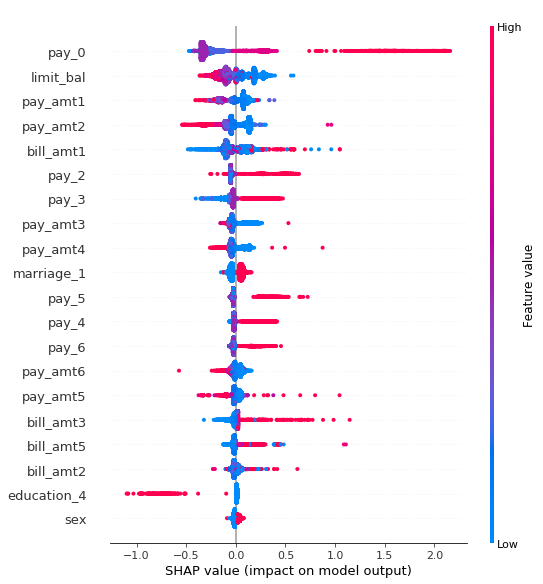

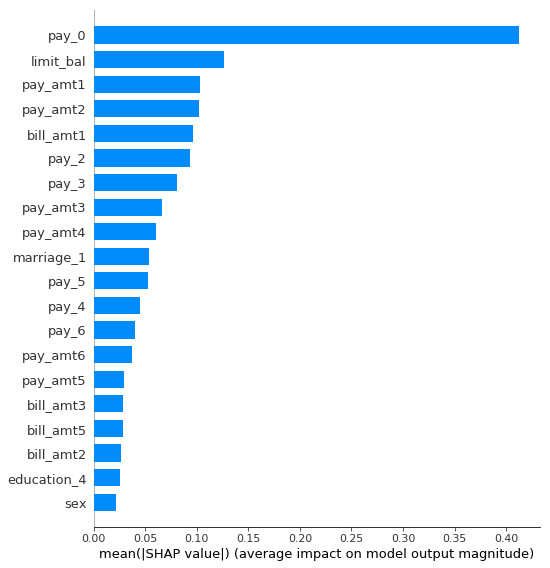

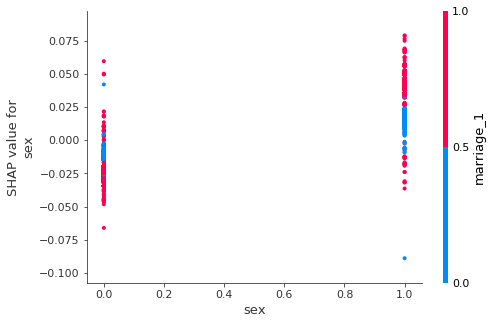

Mean SHAP value unprivileged class:  -0.01729867946474486
Mean SHAP value privileged class:  0.028130055398228698
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [28]:
print('RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_gbm, 'gbm_orig', X_train_orig, 
                                          X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [29]:
print('Global SHAP values by feature of Gradient Boosting with original data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with original data: 


,feature_names,value
0,pay_0,0.412488
1,limit_bal,0.126040
2,pay_amt1,0.102541
3,pay_amt2,0.102064
4,bill_amt1,0.095867
5,pay_2,0.093161
6,pay_3,0.080656
7,pay_amt3,0.066368
8,pay_amt4,0.060562
9,marriage_1,0.053579


RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 



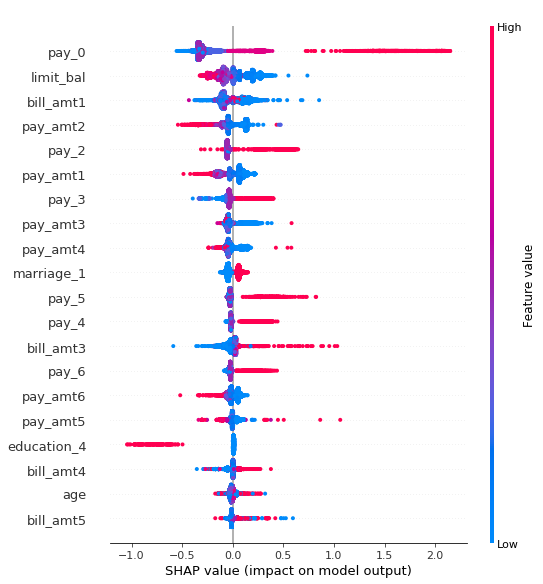

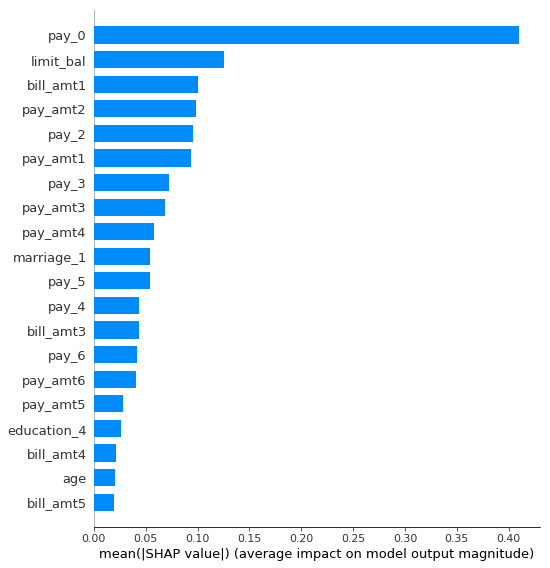

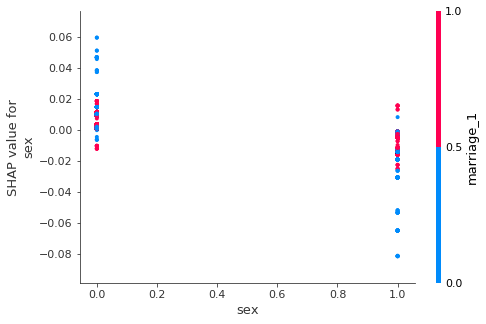

Mean SHAP value unprivileged class:  0.005961106804874302
Mean SHAP value privileged class:  -0.00894257590787655
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [30]:
print('RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_gbm, 'gbm_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [31]:
print('Global SHAP values by feature of Gradient Boosting with transformed data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with transformed data: 


,feature_names,value
0,pay_0,0.409883
1,limit_bal,0.125648
2,bill_amt1,0.100293
3,pay_amt2,0.098970
4,pay_2,0.095344
5,pay_amt1,0.093427
6,pay_3,0.072368
7,pay_amt3,0.069080
8,pay_amt4,0.057551
9,marriage_1,0.054420


### Logistic Regression

RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:05<00:00, 199.52it/s]


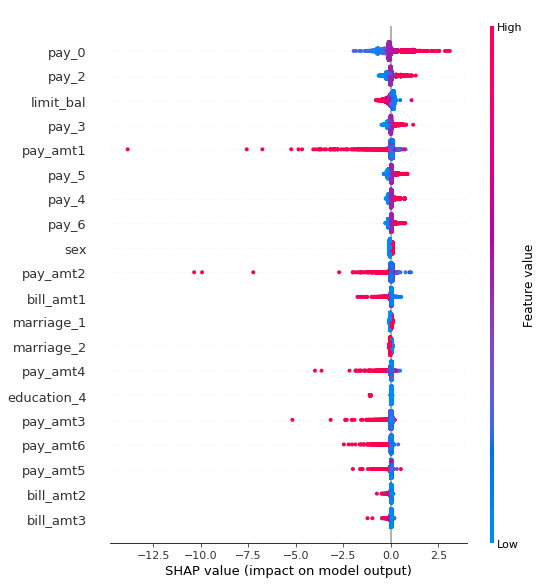

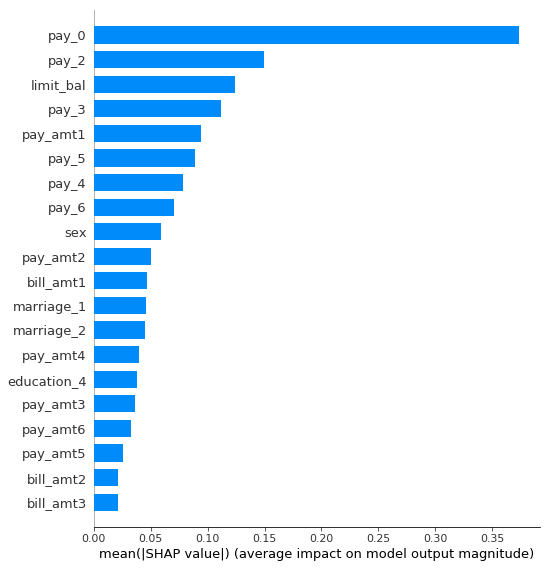

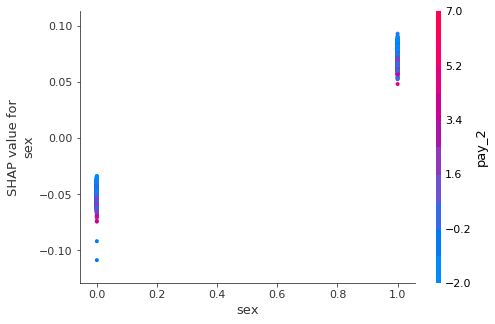

Mean SHAP value unprivileged class:  -0.04920125931779095
Mean SHAP value privileged class:  0.07505814018015884
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [32]:
print('RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_orig_lr, 'lr_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [33]:
print('Global SHAP values by feature of Logistic Regression with original data: ')
df_feat

Global SHAP values by feature of Logistic Regression with original data: 


,feature_names,value
0,pay_0,0.373564
1,pay_2,0.149632
2,limit_bal,0.123690
3,pay_3,0.111990
4,pay_amt1,0.093889
5,pay_5,0.088503
6,pay_4,0.078138
7,pay_6,0.070421
8,sex,0.059306
9,pay_amt2,0.050313


RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:06<00:00, 161.37it/s]


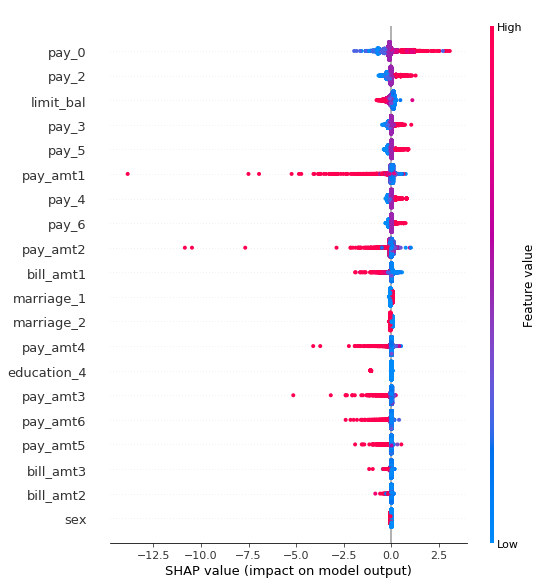

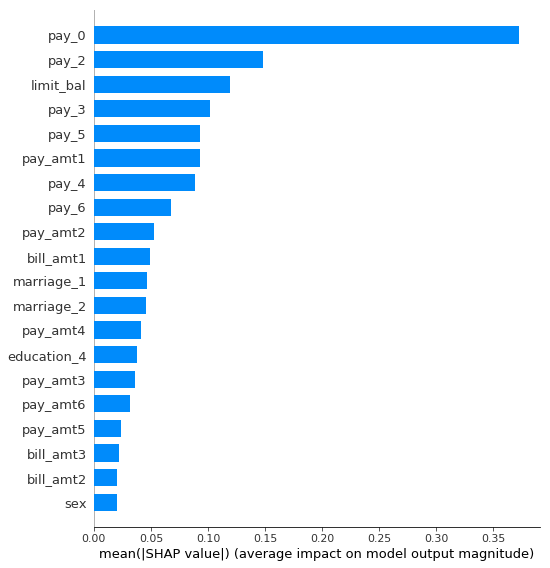

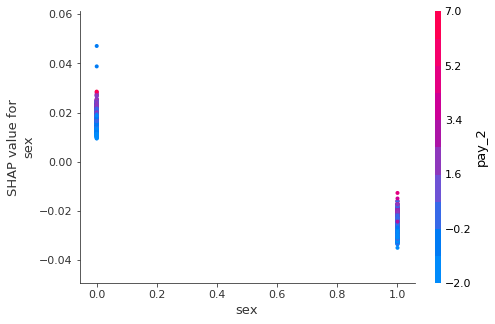

Mean SHAP value unprivileged class:  0.01701690471575881
Mean SHAP value privileged class:  -0.026096907028794615
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [34]:
print('RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_transf_lr, 'lr_transf', X_train_transf, 
                                            X_test_transf, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [35]:
print('Global SHAP values by feature of Logistic Regression with transformed data: ')
df_feat

Global SHAP values by feature of Logistic Regression with transformed data: 


,feature_names,value
0,pay_0,0.372416
1,pay_2,0.147926
2,limit_bal,0.119570
3,pay_3,0.101718
4,pay_5,0.093244
5,pay_amt1,0.092839
6,pay_4,0.088314
7,pay_6,0.067927
8,pay_amt2,0.052635
9,bill_amt1,0.049274


### Final result

In [36]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 
                                           'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_orig,0.001153,22,-0.000866,0.001430,1,default,0.835778,0.772604,-0.025927,0.772604,-0.017723,-0.025203,0.010930,0.095726,0.967711
1,rf_transf,0.000411,25,0.000252,-0.000303,0,default,0.835778,0.781803,-0.024382,0.781803,-0.014897,-0.019984,0.008919,0.095833,0.969200
2,gbm_orig,0.021827,19,-0.017299,0.028130,1,default,0.837222,0.780337,-0.025670,0.780337,-0.012635,-0.012443,-0.009270,0.094579,0.969733
3,gbm_transf,0.007181,22,0.005961,-0.008943,0,default,0.837778,0.815495,-0.020879,0.815495,-0.005096,-0.000173,-0.002920,0.094297,0.969711
4,lr_orig,0.059306,8,-0.049201,0.075058,1,default,0.823333,0.613848,-0.030633,0.613848,-0.033856,-0.053458,-0.032057,0.106391,0.975089
5,lr_transf,0.020565,19,0.017017,-0.026097,0,default,0.823778,0.888144,-0.007442,0.888144,0.006410,0.016080,0.005461,0.106018,0.975422


In [37]:
df_final.to_csv(path + 'result/resultado_default.csv')